In [40]:
#限于技术力、理解能力和时间，只能做到这了【哭哭】
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import os
import time 
import random
import math
import pandas as pd
import numpy as np
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
#导入读取数据集的函数
import mnist_reader
from IPython import display

In [41]:
"""设置matplotlib的轴"""
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [42]:
"""定义使用svg格式在Jupyter中显示绘图的函数"""
def use_svg_display():  
    backend_inline.set_matplotlib_formats('svg')

In [43]:
"""定义函数，读取Fashion-mnist数据集，并返回训练集和测试集的dataloader数据迭代器"""
def read_data(batch_size):
    
    #加载从仓库下载好的本地FashionMnist数据集
    X_train,y_train=mnist_reader.load_mnist("D:\Working\Anaconda3\envs\pytorch\Fashion_mnist\gz", kind='train')
    X_test,y_test=mnist_reader.load_mnist("D:\Working\Anaconda3\envs\pytorch\Fashion_mnist\gz", kind='t10k')
    
    #将numpy的数据类型转化为torch的张量
    X_train_tensor=torch.Tensor(X_train).reshape(-1,1,28,28)
    X_test_tensor=torch.Tensor(X_test).reshape(-1,1,28,28)
    y_train_tensor=torch.Tensor(y_train).reshape(-1,1)
    y_test_tensor=torch.Tensor(y_test).reshape(-1,1)

    #将对象存入dataset中
    mnist_train=data.TensorDataset(X_train_tensor,y_train_tensor)
    mnist_test=data.TensorDataset(X_test_tensor,y_test_tensor)

    #返回迭代器
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())#乱序 
           ,data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=get_dataloader_workers())#非乱序
           )

In [44]:
"""定义函数用于在数字标签索引及其文本名称之间进行转换"""
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

In [45]:
"""获取进程数"""
def get_dataloader_workers():
    return 4

In [46]:
"""设置批量大小"""
batch_size=256

In [47]:
"""定义函数用于样本可视化"""
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=plt.subplots(num_rows,num_cols,figsize=figsize)
    axes=axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [48]:
"""读取数据"""
train_iter,test_iter=read_data(batch_size)

In [49]:
#展平每个28*28的图像，看做长度为784的向量
num_inputs = 784
#数据集有10个类别，输出和类别一样多
num_outputs = 10

#正态分布N(0,0.01)初始化权重：784*10的矩阵
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
#初始化偏置：1*10的零向量
b = torch.zeros(num_outputs, requires_grad=True)

In [50]:
"""定义softmax函数"""
def softmax(X):
    #对矩阵内每个元素求e指数
    X_exp=torch.exp(X)
    #对指数化后的矩阵进行求行和（即小批量中每个元素的784个像素的指数求和）
    partition=X_exp.sum(1,keepdim=True)
    #利用广播机制求出并返回配分函数
    return X_exp/partition

In [51]:
"""定义softmax回归模型"""
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)

In [52]:
"""定义交叉熵损失函数"""
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y.type(torch.long)])

In [53]:
"""定义预测函数（计算预测正确的数量）"""
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [54]:
"""定义针对数据集的预测函数（计算在指定数据集上模型的精度）"""
def evaluate_accuracy(net,data_iter):
    # 将模型设置为评估模式
    if isinstance(net, torch.nn.Module):
        net.eval()  
    # 正确预测数、预测总数
    metric=Accumulator(2)  
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y), y.numel())
    return metric[0]/metric[1]

In [55]:
"""定义类对n个变量进行累加"""
class Accumulator:
    
    def __init__(self, n):
        self.data=[0.0]*n

    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]

    def reset(self):
        self.data=[0.0]*len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

In [56]:
"""构建训练过程"""
def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [57]:
"""在动画中绘制数据"""
class Animator:    
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [61]:
"""训练模型"""
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):    
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[10, 30],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 15, train_loss
    assert train_acc <= 30 and train_acc > 20, train_acc
    assert test_acc <= 30 and test_acc > 20, test_acc

In [62]:
#设置学习度为0.1
lr = 0.1

def updater(batch_size):
    return torch.optim.SGD([W, b], lr, batch_size)

AssertionError: nan

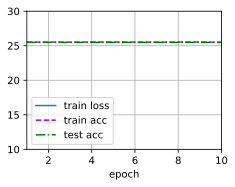

In [63]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)